In [ ]:
!pip install GPyOpt
!pip install GPy

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Nursery https://archive-beta.ics.uci.edu/dataset/76/nursery
with open("nursery.names") as f:
    print(f.read())

1. Title: Nursery Database

2. Sources:
   (a) Creator: Vladislav Rajkovic et al. (13 experts)
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Olave, V. Rajkovic, M. Bohanec: An application for admission in
   public school systems. In (I. Th. M. Snellen and W. B. H. J. van de
   Donk and J.-P. Baquiast, editors) Expert Systems in Public
   Administration, pages 145-160. Elsevier Science Publishers (North
   Holland)}, 1989.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, N

In [6]:
#dataset = UCI Car Evaluation
names=['parents','has_nurs','form','children','housing','finance','social','health','class']
df = pd.read_csv('nursery.data', names = names)
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [7]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#checking missing values
df.isnull().sum()

usual          4320
pretentious    4320
great_pret     4320
Name: parents, dtype: int64
proper         2592
less_proper    2592
improper       2592
critical       2592
very_crit      2592
Name: has_nurs, dtype: int64
complete      3240
completed     3240
incomplete    3240
foster        3240
Name: form, dtype: int64
1       3240
2       3240
3       3240
more    3240
Name: children, dtype: int64
convenient    4320
less_conv     4320
critical      4320
Name: housing, dtype: int64
convenient    6480
inconv        6480
Name: finance, dtype: int64
nonprob          4320
slightly_prob    4320
problematic      4320
Name: social, dtype: int64
recommended    4320
priority       4320
not_recom      4320
Name: health, dtype: int64
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: class, dtype: int64


parents     0
has_nurs    0
form        0
children    0
housing     0
finance     0
social      0
health      0
class       0
dtype: int64

In [8]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

df.head()
for col in names: 
    print(df[col].value_counts())

2    4320
1    4320
0    4320
Name: parents, dtype: int64
3    2592
2    2592
1    2592
0    2592
4    2592
Name: has_nurs, dtype: int64
0    3240
1    3240
3    3240
2    3240
Name: form, dtype: int64
0    3240
1    3240
2    3240
3    3240
Name: children, dtype: int64
0    4320
2    4320
1    4320
Name: housing, dtype: int64
0    6480
1    6480
Name: finance, dtype: int64
0    4320
2    4320
1    4320
Name: social, dtype: int64
2    4320
1    4320
0    4320
Name: health, dtype: int64
0    4320
1    4266
3    4044
4     328
2       2
Name: class, dtype: int64


In [9]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [10]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [12]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 6)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

In [13]:
#RF Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

{'max_features': 4, 'n_estimators': 146}
0.9901890096119754
{'max_features': 5, 'n_estimators': 135}
0.9922835848442608
{'max_features': 3, 'n_estimators': 195}
0.9868821306626385
{'max_features': 1, 'n_estimators': 68}
0.9616417098533676
{'max_features': 2, 'n_estimators': 10}
0.9624121492648952
{'max_features': 5, 'n_estimators': 185}
0.9916219419201608
{'max_features': 4, 'n_estimators': 178}
0.989307223795346
{'max_features': 6, 'n_estimators': 97}
0.9920630776777777
{'max_features': 5, 'n_estimators': 127}
0.9922834634196095
{'max_features': 5, 'n_estimators': 147}
0.991622063344812
{'max_features': 5, 'n_estimators': 158}
0.9916221847694631
{'max_features': 6, 'n_estimators': 75}
0.9916221847694633
{'max_features': 5, 'n_estimators': 9}
0.9864414806036261
{'max_features': 6, 'n_estimators': 189}
0.9922835848442608
{'max_features': 6, 'n_estimators': 176}
0.9925039705860923
{'max_features': 6, 'n_estimators': 19}
0.9911815347104508
{'max_features': 6, 'n_estimators': 29}
0.9927245

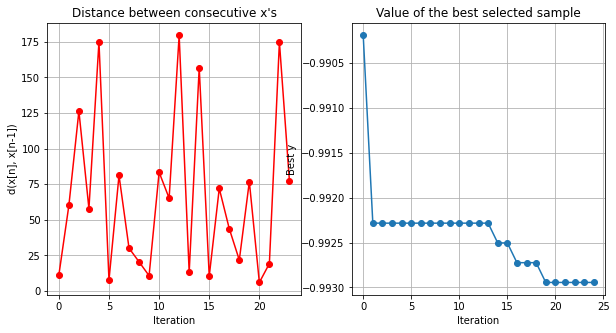

In [14]:
optimizer.plot_convergence()

In [15]:
rf_car = RandomForestClassifier(max_features=6,n_estimators=123)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9951131687242798


{'max_features': 5, 'n_estimators': 124}
0.9917324383527045
{'max_features': 2, 'n_estimators': 10}
0.9632929636843155
{'max_features': 1, 'n_estimators': 119}
0.9643970780371948
{'max_features': 4, 'n_estimators': 33}
0.9883146986968707
{'max_features': 5, 'n_estimators': 9}
0.9863324412668962
{'max_features': 5, 'n_estimators': 43}
0.9906302667942436
{'max_features': 4, 'n_estimators': 126}
0.9908502882621217
{'max_features': 4, 'n_estimators': 71}
0.9899688667194457
{'max_features': 4, 'n_estimators': 188}
0.9901891310366265
{'max_features': 5, 'n_estimators': 181}
0.9909606632700143
{'max_features': 5, 'n_estimators': 8}
0.9855593305130436
{'max_features': 4, 'n_estimators': 147}
0.9889767058949239
{'max_features': 4, 'n_estimators': 179}
0.9898580060129488
{'max_features': 4, 'n_estimators': 173}
0.9895276095371777
{'max_features': 4, 'n_estimators': 41}
0.9879845450704019
{'max_features': 4, 'n_estimators': 116}
0.9894174773785874
{'max_features': 4, 'n_estimators': 188}
0.989968

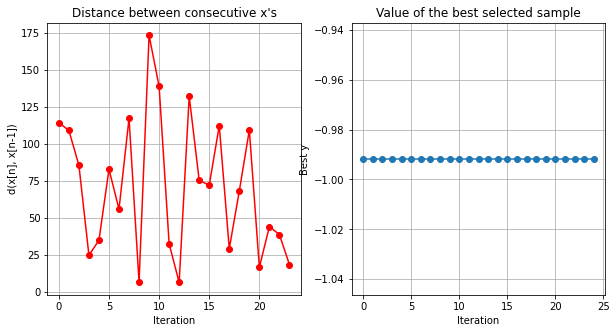

In [16]:
#RF classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [17]:
rf_car2 = RandomForestClassifier(max_features=5,n_estimators=124)
rf_car2.fit(X_train,y_train)
y_pred = rf_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9904835390946503


In [18]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 0.1)}
      ]

def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

In [19]:
#SVM Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

{'C': 0.5051561636035099, 'gamma': 0.09744048031888132}
0.9268092273020899
{'C': 0.46299865561347064, 'gamma': 0.06030511999526869}
0.9181007727464798
{'C': 0.9741693601402153, 'gamma': 0.09096519513619455}
0.9305567563104391
{'C': 0.18299013583439827, 'gamma': 0.06361372912073933}
0.9083991859691387
{'C': 0.1270492013678949, 'gamma': 0.013919211070208368}
0.8185602436264201
{'C': 0.9517436293328152, 'gamma': 0.034105639128082156}
0.9145730223567068
{'C': 1.0, 'gamma': 0.04771434879972417}
0.9235025912020556
{'C': 0.2359152167785457, 'gamma': 0.055717195960415945}
0.9099426147098679
{'C': 0.5559950896114799, 'gamma': 0.061362998673256834}
0.9201952265541141
{'C': 0.6345258311074152, 'gamma': 0.035769682189897865}
0.9133602329410507
{'C': 0.724283445050157, 'gamma': 0.027123660895262032}
0.9087304324174676
{'C': 0.3819192801052198, 'gamma': 0.049701622892583876}
0.9138010044247145
{'C': 0.81863815113593, 'gamma': 0.08895232071231482}
0.9278009024280072
{'C': 0.8545322350334646, 'gamma':

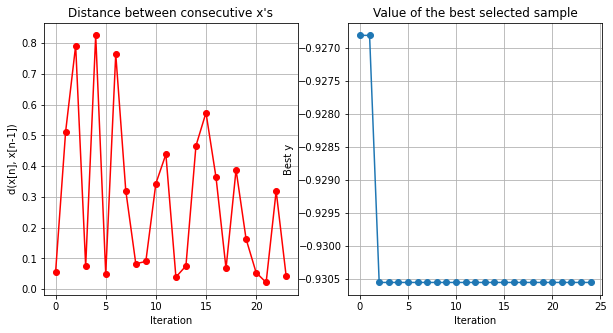

In [20]:
optimizer.plot_convergence()

In [21]:
SVM_car1 = svm.SVC(C=0.974,gamma=0.0910)
SVM_car1.fit(X_train,y_train)
y_pred = SVM_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9300411522633745


{'C': 0.407175714624615, 'gamma': 0.030534584426057353}
0.9047613034207753
{'C': 0.39051705351733523, 'gamma': 0.03240095469562906}
0.9065251179033362
{'C': 0.8044596785873233, 'gamma': 0.095653793435486}
0.9287930632525292
{'C': 0.6173223697119998, 'gamma': 0.028616563156776686}
0.9089503324606948
{'C': 0.8977765050851017, 'gamma': 0.02145285906472018}
0.9060842249950216
{'C': 0.7830733687097284, 'gamma': 0.07068547012490137}
0.9250456556688313
{'C': 0.8205035769558277, 'gamma': 0.0725249601804252}
0.9255969235850385
{'C': 0.2773895769895645, 'gamma': 0.0641344596017998}
0.9151233188757049
{'C': 0.15245865805770317, 'gamma': 0.06289868226614335}
0.9066353714865777
{'C': 1.0, 'gamma': 0.03211009860148984}
0.9143523937655728
{'C': 0.516355987033383, 'gamma': 0.020590968824619943}
0.8979269169309678
{'C': 0.7099356019992001, 'gamma': 0.045144412509879134}
0.9167780940215359
{'C': 0.8033681080485296, 'gamma': 0.04088754989859041}
0.9164472118471604
{'C': 0.7867868086618289, 'gamma': 0.050

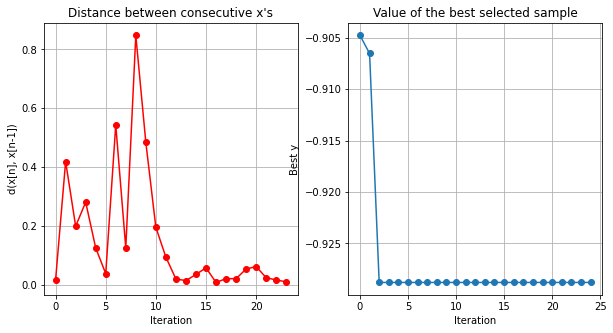

In [22]:
#SVM classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [23]:
SVM_car2 = svm.SVC(C=0.804,gamma=0.0957)
SVM_car2.fit(X_train,y_train)
y_pred = SVM_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9282407407407407


In [24]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (10, 50)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]

def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

{'leaf_size': 48.089420924755856, 'n_neighbors': 4}
0.9263685772430778
{'leaf_size': 19.61965766818022, 'n_neighbors': 4}
0.9265889629849093
{'leaf_size': 21.445542597871572, 'n_neighbors': 7}
0.9479739082709615
{'leaf_size': 33.4036098667099, 'n_neighbors': 6}
0.9441151542821616
{'leaf_size': 13.239207904670597, 'n_neighbors': 5}
0.9389342072670225
{'leaf_size': 21.556405821396265, 'n_neighbors': 6}
0.9438950113896324
{'leaf_size': 21.270696715172242, 'n_neighbors': 4}
0.9265889629849093
{'leaf_size': 21.484997710342043, 'n_neighbors': 6}
0.9438950113896324
{'leaf_size': 21.43009760577692, 'n_neighbors': 4}
0.9265889629849093
{'leaf_size': 21.549260365908495, 'n_neighbors': 3}
0.9043219890329255
{'leaf_size': 21.42850621480124, 'n_neighbors': 6}
0.9438950113896324
{'leaf_size': 21.470797707758535, 'n_neighbors': 6}
0.9438950113896324
{'leaf_size': 33.41638158233505, 'n_neighbors': 7}
0.9490765655280272
{'leaf_size': 33.47618401536002, 'n_neighbors': 3}
0.9069681964553716
{'leaf_size':

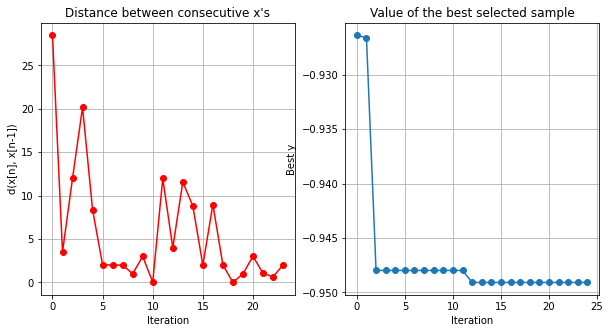

In [25]:
#KNN Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()

In [26]:
KNN_car1 = KNeighborsClassifier(leaf_size=33,n_neighbors=7)
KNN_car1.fit(X_train,y_train)
y_pred = KNN_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9495884773662552


{'leaf_size': 21.822469690250873, 'n_neighbors': 6}
0.9438950113896324
{'leaf_size': 14.42718176454861, 'n_neighbors': 4}
0.9273611023415528
{'leaf_size': 28.53634644172354, 'n_neighbors': 5}
0.9394838966627649
{'leaf_size': 41.91044314650338, 'n_neighbors': 6}
0.9441151542821616
{'leaf_size': 18.693588433305415, 'n_neighbors': 3}
0.9043219890329255
{'leaf_size': 42.245985613045605, 'n_neighbors': 7}
0.9490765655280272
{'leaf_size': 43.083564508836524, 'n_neighbors': 7}
0.9490765655280272
{'leaf_size': 42.652477419595115, 'n_neighbors': 3}
0.9069681964553716
{'leaf_size': 42.11203736913721, 'n_neighbors': 3}
0.9069681964553716
{'leaf_size': 43.09064565133573, 'n_neighbors': 6}
0.9441151542821616
{'leaf_size': 43.06299198067449, 'n_neighbors': 7}
0.9490765655280272
{'leaf_size': 42.294104451229224, 'n_neighbors': 4}
0.9263685772430778
{'leaf_size': 42.224586400276884, 'n_neighbors': 4}
0.9263685772430778
{'leaf_size': 42.25797836950893, 'n_neighbors': 4}
0.9263685772430778
{'leaf_size':

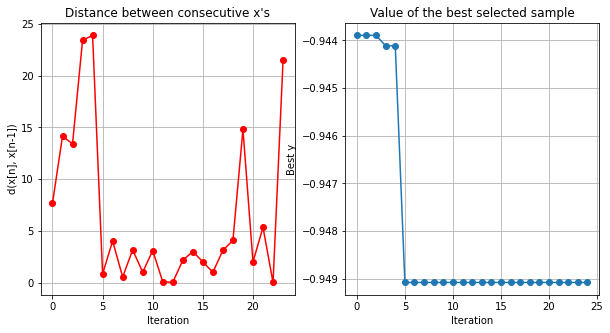

In [27]:
#KNN Classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()

In [28]:
KNN_car2 = KNeighborsClassifier(leaf_size=42,n_neighbors=7)
KNN_car2.fit(X_train,y_train)
y_pred = KNN_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9488168724279835
